In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 데이터 로드
df = pd.read_csv('D:/Ryu/Ryusdata/train.csv')
X = df.drop(columns=['SUBCLASS', 'ID'])
y = df['SUBCLASS']

In [3]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6201 entries, 0 to 6200
Columns: 4384 entries, A2M to ZYX
dtypes: object(4384)
memory usage: 207.4+ MB


In [4]:
# 암종별 유전체 데이터 불러오기
ACC = pd.read_csv("D:/Ryu/Ryusdata/cosmic/ACC.csv")
BLCA = pd.read_csv("D:/Ryu/Ryusdata/cosmic/BLCA.csv")
BRCA = pd.read_csv("D:/Ryu/Ryusdata/cosmic/BRCA.csv")
CESC = pd.read_csv("D:/Ryu/Ryusdata/cosmic/CESC.csv")
COAD = pd.read_csv("D:/Ryu/Ryusdata/cosmic/COAD.csv")
DLBC = pd.read_csv("D:/Ryu/Ryusdata/cosmic/DLBC.csv")
GBMLGG = pd.read_csv("D:/Ryu/Ryusdata/cosmic/GBMLGG.csv")
HNSC = pd.read_csv("D:/Ryu/Ryusdata/cosmic/HNSC.csv")
KIPAN = pd.read_csv("D:/Ryu/Ryusdata/cosmic/KIPAN.csv")
KIRC = pd.read_csv("D:/Ryu/Ryusdata/cosmic/KIRC.csv")
LAML = pd.read_csv("D:/Ryu/Ryusdata/cosmic/LAML.csv")
LGG1 = pd.read_csv("D:/Ryu/Ryusdata/cosmic/LGG_astGrade2.csv")
LGG2 = pd.read_csv("D:/Ryu/Ryusdata/cosmic/LGG_astGrade3.csv")
LIHC = pd.read_csv("D:/Ryu/Ryusdata/cosmic/LIHC.csv")
LUAD = pd.read_csv("D:/Ryu/Ryusdata/cosmic/LUAD.csv")
LUSC = pd.read_csv("D:/Ryu/Ryusdata/cosmic/LUSC.csv")
OV = pd.read_csv("D:/Ryu/Ryusdata/cosmic/OV.csv")
PAAD = pd.read_csv("D:/Ryu/Ryusdata/cosmic/PAAD.csv")
PCPG = pd.read_csv("D:/Ryu/Ryusdata/cosmic/PCPG.csv")
PRAD = pd.read_csv("D:/Ryu/Ryusdata/cosmic/PRAD.csv")
SARC1 = pd.read_csv("D:/Ryu/Ryusdata/cosmic/SARC_bone.csv")
SARC2 = pd.read_csv("D:/Ryu/Ryusdata/cosmic/SARC_SoftTissue.csv")
SKCM = pd.read_csv("D:/Ryu/Ryusdata/cosmic/SKCM.csv")
STES = pd.read_csv("D:/Ryu/Ryusdata/cosmic/STES.csv")
TGCT = pd.read_csv("D:/Ryu/Ryusdata/cosmic/TGCT.csv")
THCA = pd.read_csv("D:/Ryu/Ryusdata/cosmic/THCA.csv")
THYM = pd.read_csv("D:/Ryu/Ryusdata/cosmic/THYM.csv")
UCEC = pd.read_csv("D:/Ryu/Ryusdata/cosmic/UCEC.csv")
cancer_list = [ACC, BLCA, BRCA, CESC, COAD, DLBC, GBMLGG, HNSC, KIPAN, KIRC, LAML, LGG1, LGG2, LIHC, LUAD,
               LUSC, OV, PAAD, PCPG, PRAD, SARC1, SARC2, SKCM, STES, TGCT, THCA, THYM, UCEC]

In [5]:
for i in cancer_list:
    print(len(i))

8188
49585
54175
49556
54935
4194
54147
51691
49585
49459
371
3454
28389
54146
54340
54601
45474
54460
1261
55171
16946
52956
31115
39335
4617
1274
1744
119


In [6]:
for index, cancer in enumerate(cancer_list):
    cancer['Mutation rate'] = cancer['Mutated samples'] / cancer['Samples tested']
    cancer_list[index] = cancer[cancer['Mutation rate'] > 0.05] # 실험 데이터에서 변이 빈도 > 5% 
for i in cancer_list:
    print(len(i))

60
3067
14309
935
3970
564
102
1315
3067
73
231
106
592
499
1746
2515
133
6001
38
4732
367
967
31115
15480
393
134
1680
104


In [7]:
# 모든 Gene name과 X의 열 이름이 일치하는 데이터만 남기는 함수 정의
def filter_genes_by_X(cancer_df, X):
    # X의 열 이름을 가져와서 Gene name으로 일치하는 데이터만 필터링
    gene_names = X.columns
    filtered_df = cancer_df[cancer_df['Gene name'].isin(gene_names)]
    return filtered_df

# 불러온 모든 암종별 유전체 데이터를 X와 비교하여 필터링
filtered_cancer_list = [filter_genes_by_X(cancer_df, X) for cancer_df in cancer_list]

# 필요시 하나의 데이터프레임으로 합치기
filtered_combined_df = pd.concat(filtered_cancer_list, ignore_index=True)

# 이제 X에서 필터링된 유전자(Gene name)에 해당하는 열만 남기기
filtered_gene_names = filtered_combined_df['Gene name'].unique()  # 중복 제거한 유전자 이름 리스트
X_filtered = X[filtered_gene_names]  # X에서 해당 유전자 이름에 해당하는 열만 선택

# 결과 출력 (일부만 출력)
print(X_filtered.head())

    TP53 CTNNB1 NF1 FGFR3 PIK3CA HRAS KMT2D    RB1 ERBB2 TSC1  ... NBN FUT4  \
0     WT     WT  WT    WT     WT   WT    WT     WT    WT   WT  ...  WT   WT   
1  M237I     WT  WT    WT     WT   WT    WT     WT    WT   WT  ...  WT   WT   
2     WT     WT  WT    WT     WT   WT    WT  Q257*    WT   WT  ...  WT   WT   
3     WT     WT  WT    WT     WT   WT    WT     WT    WT   WT  ...  WT   WT   
4  M246R     WT  WT    WT     WT   WT    WT     WT    WT   WT  ...  WT   WT   

  COX5B IFITM3 CDK8 PHB2 HSD11B2 CASP1 HNF1A PIK3CB  
0    WT     WT   WT   WT      WT    WT    WT     WT  
1    WT     WT   WT   WT      WT    WT    WT     WT  
2    WT     WT   WT   WT      WT    WT    WT     WT  
3    WT     WT   WT   WT      WT    WT    WT     WT  
4    WT     WT   WT   WT      WT    WT    WT     WT  

[5 rows x 2926 columns]


In [8]:
# 변이 정보를 분리하는 함수
def variant_presence(feature):
    if pd.isna(feature):
        return 0  # 변이가 없는 경우
    return 1 if feature != 'WT' else 0  # 변이가 있으면 1, WT면 0

df_variants = X_filtered.applymap(variant_presence)

X_encoded = pd.DataFrame(df_variants.values, columns=X_filtered.columns)
X_encoded

,TP53,CTNNB1,NF1,FGFR3,PIK3CA,HRAS,KMT2D,RB1,ERBB2,TSC1,...,NBN,FUT4,COX5B,IFITM3,CDK8,PHB2,HSD11B2,CASP1,HNF1A,PIK3CB
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6196,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6197,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6199,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# 타겟 변수 인코딩
le_subclass = LabelEncoder()
y_encoded = le_subclass.fit_transform(y)
for i, label in enumerate(le_subclass.classes_):
    print(f"원래 레이블: {label}, 변환된 숫자: {i}")

원래 레이블: ACC, 변환된 숫자: 0
원래 레이블: BLCA, 변환된 숫자: 1
원래 레이블: BRCA, 변환된 숫자: 2
원래 레이블: CESC, 변환된 숫자: 3
원래 레이블: COAD, 변환된 숫자: 4
원래 레이블: DLBC, 변환된 숫자: 5
원래 레이블: GBMLGG, 변환된 숫자: 6
원래 레이블: HNSC, 변환된 숫자: 7
원래 레이블: KIPAN, 변환된 숫자: 8
원래 레이블: KIRC, 변환된 숫자: 9
원래 레이블: LAML, 변환된 숫자: 10
원래 레이블: LGG, 변환된 숫자: 11
원래 레이블: LIHC, 변환된 숫자: 12
원래 레이블: LUAD, 변환된 숫자: 13
원래 레이블: LUSC, 변환된 숫자: 14
원래 레이블: OV, 변환된 숫자: 15
원래 레이블: PAAD, 변환된 숫자: 16
원래 레이블: PCPG, 변환된 숫자: 17
원래 레이블: PRAD, 변환된 숫자: 18
원래 레이블: SARC, 변환된 숫자: 19
원래 레이블: SKCM, 변환된 숫자: 20
원래 레이블: STES, 변환된 숫자: 21
원래 레이블: TGCT, 변환된 숫자: 22
원래 레이블: THCA, 변환된 숫자: 23
원래 레이블: THYM, 변환된 숫자: 24
원래 레이블: UCEC, 변환된 숫자: 25


In [10]:
# 학습 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42, shuffle=True)

In [11]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [12]:
import torch
device = 'gpu' if torch.cuda.is_available() else 'cpu'

# 모델 정의
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', tree_method='gpu_hist', n_jobs=-1)
svm_model = SVC(probability=True)  # 확률 예측을 위해 probability=True 설정
cat_model = CatBoostClassifier(iterations=250, learning_rate=0.01, depth=15, random_seed=42, loss_function='MultiClass', task_type='GPU' if device == 'gpu' else 'CPU', thread_count=-1)
knn_model = KNeighborsClassifier(n_neighbors=10, n_jobs=-1)
logreg_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=250, n_jobs=-1)


# Voting Classifier 정의 (soft voting)
stacking_clf = StackingClassifier(estimators=[
    ('xgb', xgb_model),
    ('svm', svm_model),
    ('knn', knn_model)
], final_estimator=logreg_model)

In [13]:
import gc
gc.collect()

11

In [14]:
# 모델 학습
# voting_clf.fit(X_train, y_train)
stacking_clf.fit(X_train, y_train)

# 평가
# accuracy = voting_clf.score(X_test, y_test)
accuracy = stacking_clf.score(X_test, y_test)
print(f'Voting Classifier Test Accuracy: {accuracy:.4f}')

Voting Classifier Test Accuracy: 0.4255


In [15]:
# y_pred = voting_clf.predict(X_test)
y_pred = stacking_clf.predict(X_test)

In [16]:
print(accuracy_score(y_test, y_pred))

0.4254633360193392


In [17]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.50      0.67        14
           1       1.00      0.22      0.36        27
           2       0.35      0.57      0.43       149
           3       0.00      0.00      0.00        31
           4       0.56      0.63      0.59        30
           5       1.00      0.10      0.18        10
           6       0.61      0.59      0.60       116
           7       0.50      0.29      0.37        51
           8       0.33      0.67      0.45        86
           9       0.63      0.44      0.52        54
          10       0.26      0.33      0.29        39
          11       0.62      0.47      0.53        49
          12       0.38      0.15      0.21        34
          13       0.50      0.16      0.24        37
          14       0.35      0.15      0.21        39
          15       0.38      0.41      0.40        58
          16       0.33      0.04      0.07        24
          17       0.46    

In [18]:
print(confusion_matrix(y_test, y_pred))

[[ 7  0  1  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  2  1  2  0
   0  0]
 [ 0  6  2  0  1  0  1  2  3  0  0  0  0  0  0  0  0  0  0  0  0 11  0  0
   0  1]
 [ 0  0 85  0  1  0  1  0  9  0  6  0  0  0  0 15  0  2 15  1  1 11  0  0
   0  2]
 [ 0  0 11  0  0  0  0  0 11  0  2  0  0  0  0  0  0  0  2  0  0  5  0  0
   0  0]
 [ 0  0  1  0 19  0  0  0  1  0  0  0  0  0  0  0  1  0  1  0  4  3  0  0
   0  0]
 [ 0  0  2  0  0  1  0  0  2  1  0  0  0  0  0  0  0  0  1  0  2  1  0  0
   0  0]
 [ 0  0 15  0  0  0 68  0 10  0  2  9  0  0  0  6  0  0  0  0  0  2  1  1
   0  2]
 [ 0  0  7  0  1  0  1 15  4  0  0  0  1  0  3  3  0  0  1  0  2 11  1  0
   0  1]
 [ 0  0 10  0  1  0  0  0 58  7  0  0  0  0  0  1  0  0  5  3  0  0  1  0
   0  0]
 [ 0  0  5  0  1  0  0  0 19 24  1  0  0  0  0  0  0  0  4  0  0  0  0  0
   0  0]
 [ 0  0  7  0  0  0  1  0  1  0 13  5  0  0  0  2  0  2  6  0  0  0  0  2
   0  0]
 [ 0  0  2  0  0  0 20  0  0  0  0 23  0  0  0  0  0  0  1  2  0  0  0  1
   0  0]
 [ 0

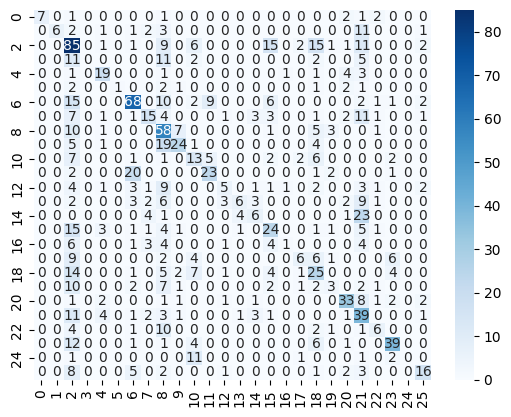

In [19]:
import seaborn as sns
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.show()

In [20]:
# 테스트 데이터 로드
test = pd.read_csv("D:/Ryu/Ryusdata/test.csv")

# 테스트 데이터에서 'ID' 열 제거
X_test = test.drop(columns=['ID'])

In [21]:
# 학습 데이터에서 필터링된 유전자(Gene name) 목록을 사용하여 테스트 데이터 필터링
filtered_gene_names = filtered_combined_df['Gene name'].unique()  # 필터링된 유전자 이름 리스트
X_test_filtered = X_test[filtered_gene_names]

In [26]:
df_variants_test = X_test_filtered.applymap(variant_presence)

X_test_encoded = df_variants_test.values
y_pred_test = stacking_clf.predict(X_test_encoded)

In [27]:
submission_df = pd.DataFrame({
    'ID': test['ID'], 
    'SUBCLASS': le_subclass.inverse_transform(y_pred_test) 
})

In [28]:
# 결과 확인
print(submission_df.head())

# CSV 파일로 저장
submission_df.to_csv('D:/Ryu/Ryusdata/stacking_predictions1.csv', index=False)

          ID SUBCLASS
0  TEST_0000     STES
1  TEST_0001     UCEC
2  TEST_0002     BRCA
3  TEST_0003   GBMLGG
4  TEST_0004     HNSC
